In [1]:
import numpy as np
import torch
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from src.rl_env import CreditLimitEnv
from src.dqn import DQN, train_dqn
from src.evaluation import EvaluationUtils

Loading cleaned data...
Full Data Shape: (40406, 14)
Using stratified sample...
Sampled Shape: (4041, 14)
Initializing environment...
State space: ['BALANCE_CLASS', 'UR', 'PR', 'D_PROVISION_bin'] | Action space: [0, 1]
Sample size: 4041
Training new model...
Training Device      : cuda
Episode   1 | Reward:  286.1378 | Epsilon: 0.9950 | Best: 286.1378
Episode   2 | Reward:  230.5868 | Epsilon: 0.9900 | Best: 286.1378
Episode   3 | Reward:   79.9334 | Epsilon: 0.9851 | Best: 286.1378
Episode   4 | Reward:  155.3526 | Epsilon: 0.9801 | Best: 286.1378
Episode   5 | Reward:  335.4130 | Epsilon: 0.9752 | Best: 335.4130
Episode   6 | Reward:   26.0036 | Epsilon: 0.9704 | Best: 335.4130
Episode   7 | Reward:  232.4653 | Epsilon: 0.9655 | Best: 335.4130
Episode   8 | Reward:  269.8169 | Epsilon: 0.9607 | Best: 335.4130
Episode   9 | Reward:  338.1316 | Epsilon: 0.9559 | Best: 338.1316
Episode  10 | Reward:  343.1240 | Epsilon: 0.9511 | Best: 343.1240
Episode  11 | Reward:  335.6390 | Epsilon: 

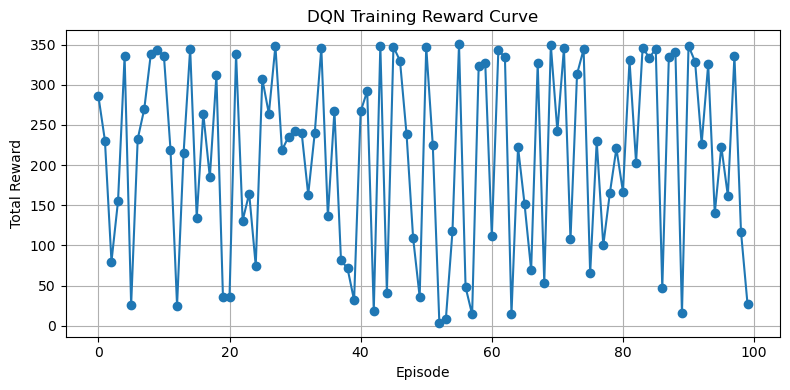


Evaluating RL Agent and Benchmarks...


=== Simulated Rewards ===
RL Agent         : 173.0821
Random           : 158.1540
Never Increase   : 298.1915
Always Increase  : 225.4129

=== Real (Ground-Truth) Rewards ===
RL Agent         : 186.2381
Random           : 170.0646
Never Increase   : 319.6274
Always Increase  : 241.1293


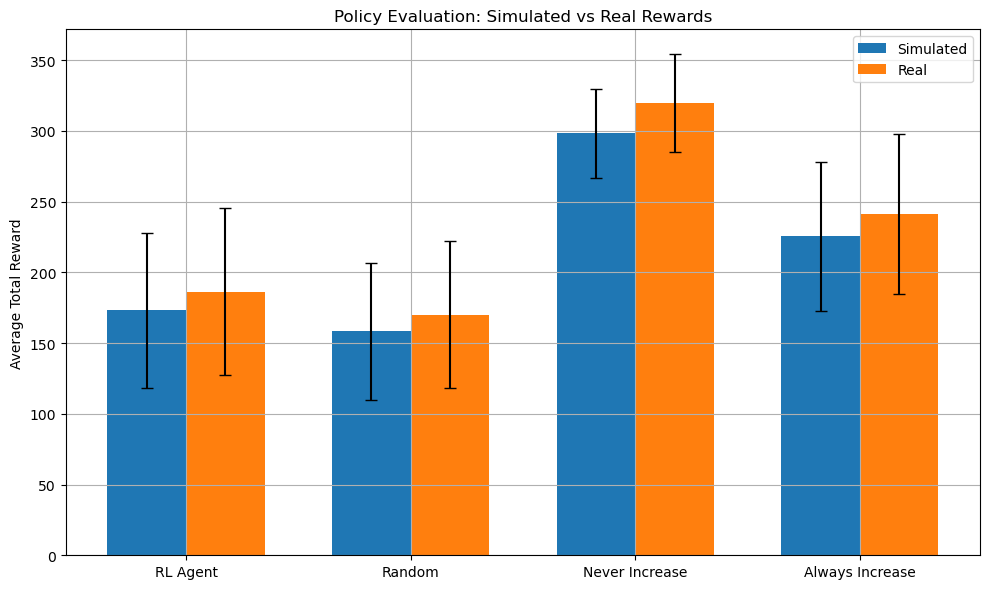

In [2]:
# === CONFIG ===
DEBUG_MODE = True       # toggle this
SAMPLE_FRAC = 0.1       # only used if DEBUG_MODE = True
EPISODES = 100
N_RUNS = 5

# === Step 1: Load processed dataset ===
print("Loading cleaned data...")
full_df = pd.read_csv("data/processed/cleaned_df.csv")
print("Full Data Shape:", full_df.shape)

# === Step 2: Optionally stratified sample for debug ===
if DEBUG_MODE:
    print("Using stratified sample...")
    full_df["STRATA"] = full_df["BALANCE_CLASS"].astype(str) + "_" + full_df["D_PROVISION_bin"].astype(str)
    sampled_df = (
        full_df.groupby("STRATA", group_keys=False)
        .apply(lambda x: x.sample(frac=SAMPLE_FRAC, random_state=42))
        .reset_index(drop=True)
    )
    final_df = sampled_df.drop(columns=["STRATA"])
    print("Sampled Shape:", final_df.shape)
else:
    final_df = full_df

# === Step 3: Set global provision bins & initialize env ===
provision_bins = np.arange(-0.5, 1.51, 0.01)
globals()["provision_bins"] = provision_bins

print("Initializing environment...")
env = CreditLimitEnv(final_df, provision_bins=provision_bins)
print(f"State space: {env.state_space} | Action space: {env.action_space}")
print(f"Sample size: {env.n_customers}")

# === Step 4: Load or train DQN model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(env.state_space)
output_dim = len(env.action_space)
model_path = "models/best_dqn_model.pth"

model = DQN(input_dim, output_dim).to(device)

if os.path.exists(model_path) and not DEBUG_MODE:
    print(f"Loading pretrained model from {model_path}...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    reward_history = None
else:
    print("Training new model...")
    model, _, reward_history, _ = train_dqn(env, episodes=EPISODES, model_path=(None if DEBUG_MODE else model_path))

    # === Step 5: Plot training rewards ===
if reward_history is not None and len(reward_history) > 0:
    EvaluationUtils.plot_training_reward_history(reward_history)

# === Step 6: Wrap agent ===
agent = EvaluationUtils.DQNAgent(model, env.action_space)

# === Step 7: Evaluate RL and benchmarks ===
print("\nEvaluating RL Agent and Benchmarks...\n")
rl_sim, rl_real     = EvaluationUtils.evaluate_policy(agent, env, n_runs=N_RUNS)
rand_sim, rand_real = EvaluationUtils.evaluate_policy(None, env, n_runs=N_RUNS, benchmark="random")
no_sim, no_real     = EvaluationUtils.evaluate_policy(None, env, n_runs=N_RUNS, benchmark="never_increase")
all_sim, all_real   = EvaluationUtils.evaluate_policy(None, env, n_runs=N_RUNS, benchmark="always_increase")

# === Step 8: Package results ===
sim_results = {
    "RL Agent": rl_sim,
    "Random": rand_sim,
    "Never Increase": no_sim,
    "Always Increase": all_sim
}

real_results = {
    "RL Agent": rl_real,
    "Random": rand_real,
    "Never Increase": no_real,
    "Always Increase": all_real
}

# === Step 9: Print summary ===
print("\n=== Simulated Rewards ===")
for name, rewards in sim_results.items():
    print(f"{name:17s}: {np.mean(rewards):.4f}")

print("\n=== Real (Ground-Truth) Rewards ===")
for name, rewards in real_results.items():
    print(f"{name:17s}: {np.mean(rewards):.4f}")

# === Step 10: Plot ===
EvaluationUtils.plot_policy_comparison(sim_results, real_results)